### 변동성 돌파전략 3
이전 단원에서 최적의 K 를 찾아보았는데요. 이번에는 K 를 고정하고 최적의 종목을 찾아보겠습니다. 코스피로 한정해서 종목을 찾아보겠습니다. FinanceDataReaer 의 StockListing 메소드의 인수로 'KOSPI' 를 넣으면 코스피 모든 종목을 반환합니다.

In [1]:
import FinanceDataReader as fdr 
import pandas as pd
import numpy as np

kospi_df = fdr.StockListing('KOSPI')
kospi_df.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
6,152100,KOSPI,ARIRANG 200,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,295820,KOSPI,ARIRANG 200동일가중,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,253150,KOSPI,ARIRANG 200선물레버리지,NaN,NaN,NaT,NaN,NaN,NaN,NaN


<br> nunique() 은 유니크한 종목 수를 세는 메소드입니다. 6,361 개의 종목이 있습니다. Sector 가 비어있는 종목의 경우는 일반적인 회사의 종목이 아닌 것인 것으로 보입니다. Sector 가 비어있는 종목은 제외하겠습니다. 이제 820 개의 종목만 남았습니다.

In [15]:
print(kospi_df['Symbol'].nunique())
print(kospi_df[~kospi_df['Sector'].isnull()]['Symbol'].nunique())

6361
820


<br> kospi_df 에서 필요한 컬럼 'Symbol' 과 'Name' 두 개만 kospi_list DataFrame 에 저장합니다. 그리고 종목코드 'Symbol' 과 'Name' 을 각 각 'code' 외 'name' 으로 바꿔줍니다. 그리고 나중을 위해서 결과물을 pickle 파일로 저장도 합니다.

In [16]:
kospi_list = kospi_df[~kospi_df['Sector'].isnull()][['Symbol','Name']].rename(columns={'Symbol':'code','Name':'name'})
kospi_list.to_pickle('kospi_list.pkl')

<br> 이제 변동성 돌파 전략의 수익율을 계산하는 함수를 불러옵니다. 일단 K 는 0.5 로 고정합니다. 모든 코스피 종목을 For-Loop 하면서 가장 수익율이 좋은 종목을 찾으면 됩니다. Loop 를 돌 때마다 종목이름, 종목코드, 평균수익율, 최대손실, 누적수익율을 list 에 저장합니다. 마지막으로 모든 list 를 모아서 하나의 DataFrame 으로 저장합니다. 800 개가 넘는 종목을 Loop 로 하나 씩 하니 시간이 많이 걸립니다. time 모듈을 이용해 총 데이터 처리시간도 측정해 봅니다. 2021년 변동성 돌파전략으로 매수할 수 있는 날이 50일 미만 경우는 무시하도록 if 문을 만들었습니다. 최종 결과를 pickle 로 저장합니다. 

In [48]:
import time

start_time = time.time()
K = 0.5

def avg_r(code, K):
    stock = fdr.DataReader(code,  start='2021-01-03', end='2021-12-31')    
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High']  > stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    return len(stock[stock['buy']==1]), stock[stock['buy']==1]['return'].mean(), stock[stock['buy']==1]['return'].min(), stock[stock['buy']==1]['return'].prod()

code_list = []
name_list = []
return_list = []
worst_list = []
cumul_list = []

for code, name in zip(kospi_list['code'], kospi_list['name']):

    n, r, w, c = avg_r(code, K)

    if n >= 50: # 최소한 50일 이상 거래일 존재해야 진행

        code_list.append(code)
        name_list.append(name)
        return_list.append(r)
        worst_list.append(w)
        cumul_list.append(c)
        
    else:
        continue

outcome = pd.DataFrame({'code':code_list, 'name': name_list, 'return': return_list, 'worst': worst_list, 'cumul': cumul_list})    
outcome.to_pickle('outcome.pkl')

print(f'총 프로세싱 시간 {time.time() - start_time}')

총 프로세싱 시간 100.75618124008179


<br> 저장된 결과물 outcome 을 'return' 값의 내림차순으로 함 보겠습니다. 수익율이 좋은 종목 Top 3 는 '조일알미늄', '한전기술', '포스코스틸리온' 이였습니다. Top 10 에서 최대손실율을 동시에 고려하면, 2021년에는 '미원화학'이 좋아 보입니다. 미원화학을 2021년 초부터 변동성 돌파전략으로 매수 매도를 했으면 2021년 연말에는 원금의 2.9배가 되어 있었을 것입니다. 하지만, 지나간 일입니다. 이 책의 4장부터는 데이터 분석으로 미래를 예측하는 방법을 다룹니다.

In [49]:
outcome.sort_values(by='return', ascending=False).head(10)

,code,name,return,worst,cumul
570,018470,조일알미늄,1.017648,0.907132,4.549524
722,052690,한전기술,1.017243,0.932258,5.318219
645,058430,포스코스틸리온,1.016921,0.868904,3.838723
274,092200,디아이씨,1.016628,0.896846,3.478830
546,008500,일정실업,1.016182,0.928633,4.006988
318,134380,미원화학,1.015959,0.966864,2.918914
667,004090,한국석유,1.015428,0.914433,2.984814
773,010690,화신,1.014677,0.921250,3.405889
225,001440,대한전선,1.014668,0.706109,3.403380
594,001620,케이비아이동국실업,1.014626,0.932897,3.121872


<br> 미원화학의 2021년 주가흐름을 함 보겠습니다. 2021년 3월에 급등이 있었습니다. 

<AxesSubplot:xlabel='Date'>

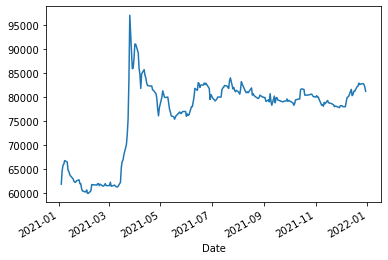

In [50]:
code = '134380' # 미원화학
stock_data = fdr.DataReader(code, start='2021-01-03', end='2021-12-31') 
stock_data['Close'].plot()